In [1]:
#Load the packages
#import torch
#import torch.nn as nn
from lightning.pytorch import Trainer #https://lightning.ai/docs/pytorch/stable/common/trainer.html
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping #3
from lightning.pytorch.loggers import TensorBoardLogger #3
from maldi_zsl_edit.data import MALDITOFDataModule #1
from maldi_zsl_edit.models import ZSLClassifier #2
#import h5py
#import numpy as np

In [2]:
#Load the data set
dm = MALDITOFDataModule( #Personalized lightning data modules
    "../Data/zsl_binned_new.h5t", #The old has problems on split
    zsl_mode = True, # False: multi-class CLF, True: ZSL
    split_index = 0, # independent train-val-test split numbered 0-9
    batch_size = 128, # important hyperparameter
    n_workers = 2, # you can leave this always if you are not CPU limited
    in_memory = True, # you can leave this always if memory is no problem
    )

dm.setup(None)
#batch = next(iter(dm.train_dataloader()))
#batch.keys()

# Training

In [5]:
#Now there should be a batch instance ["seq_ohe]", replace the batch["seq"] with it in the models file
n_species = 160 #batch['strain'].shape[0] #Number the seq considered for the train, #The batch should be 623 (463 of training and 160 of val, the rest 165 are on test)
t_species = 463
#To add the correct number of n_species you need to correct the sequences seen per batch
model = ZSLClassifier(
    embed_dim=1024, #520
    #mlp_kwargs = { #specify the parameters to buld the MLP ()
    #    'n_inputs' : 6000, #Bins of the spectra
    #    'layer_dims': [512, 256],
    #    'layer_or_batchnorm' : "layer",
    #    'dropout' : 0.2,
    #},
    cnn_kwargs= { #specify the parameters to buld the CNN ()
        #'vocab_size' : 6, #Number of words, in this case is 5 as (A,T,C,G,-)
        'conv_sizes' : [64, 128], #[32, 64, 128] Out chanels of the convolutions #On the nlp mode the first is an embeding dimension
        'hidden_sizes' : [0], #MLP: [512, 256]. If [0] then goes directly from conv to embeding layer
        #IMPORTANT: The models for classification have first the convolution and then a MLP, consider to also add the MLP in the model
        #Note: The first hidden state is the embedding dim of the seq language processing and need to be optimized
        #Note2: The last is the embedding dim for the shared space and score function
        'blocks_per_stage' : 2, #How many residual blocks are applied before the pooling
        'kernel_size' : 7,
        #Stride?
        #Max average or non?
        'dropout' : 0.2,
    },
    n_classes = n_species,
    t_classes = t_species,
    lr=1e-4, # important to tune
    weight_decay=0, # this you can keep constant
    lr_decay_factor=1.00, # this you can keep constant
    warmup_steps=250, # this you can keep constant
    #nlp = False #Try
)


In [3]:
#Save and monitor training with tensor board
from datetime import datetime
timenow = datetime.now()
strtime = timenow.strftime("%Y-%m-%d_%H-%M-%S")

val_ckpt = ModelCheckpoint(monitor="val_acc", mode="max")
callbacks = [val_ckpt, EarlyStopping(monitor="val_acc", patience=20, mode="max")]
logger = TensorBoardLogger("../logs_folder", name="zsl_train_try2", version=strtime) # Ctrl+Shift+P # Main folder where the training is saved and the name for the training

#Training specification
trainer = Trainer(
    max_epochs = 100, 
    accelerator='gpu', 
    strategy='auto',
    callbacks=callbacks,
    logger=logger,
    devices=[0]) #You can define epochs and training devices (look on documentation)



/home/jorge/anaconda3/envs/Thesis/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
#Load from check point
sure = False
if sure:
    from torch import load as torch_load
    checkpoint = torch_load('../logs_folder/zsl_train_try2/2024-07-22_06-25-16/checkpoints/epoch=56-step=60078.ckpt')
    
    for name, param in checkpoint['state_dict'].items():
        print(f"Key: {name}, Shape: {param.shape}")
    for name, param in model.state_dict().items():
        print(f"Key: {name}, Shape: {param.shape}")
    model.state_dict().keys() == checkpoint['state_dict'].keys()

    model.load_state_dict(checkpoint['state_dict'])


In [6]:
#Start training
trainer.fit(model, dm.train_dataloader(), dm.val_dataloader()) #Important: normally you can use only dm, but here we specify as the dim of a are different for train and val 
#Note: The model object specify what is considered an input values and what is considered an input/output value during the training on the training step method

/home/jorge/anaconda3/envs/Thesis/lib/python3.11/site-packages/torch/cuda/__init__.py:190: UserWarning: 
    Found GPU1 NVIDIA Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(
2024-07-31 11:28:03.576737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 11:28:04.329450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type               | Params
---------------------------------------------------------
0 | spectrum_embedder | MLPEmbedding       | 3.6 M 
1 | seq_embedder      | CNNEmbeddin

Sanity Checking: 0it [00:00, ?it/s]

/home/jorge/anaconda3/envs/Thesis/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
Epoch 0 - Train loss: NA, Train accu: 0.0
Epoch 0 - Val loss: 11.303028106689453, Val accu: 0.0

                                                                           

/home/jorge/anaconda3/envs/Thesis/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 132/132 [01:14<00:00,  1.76it/s, v_num=7-43]
Epoch 0 - Train loss: 12.093050956726074, Train accu: 0.0020123105496168137
Epoch 0 - Val loss: 5.062895774841309, Val accu: 0.010638297535479069

Epoch 1: 100%|██████████| 132/132 [01:19<00:00,  1.66it/s, v_num=7-43]
Epoch 1 - Train loss: 7.02711820602417, Train accu: 0.0022490532137453556
Epoch 1 - Val loss: 5.067542552947998, Val accu: 0.010638297535479069

Epoch 2: 100%|██████████| 132/132 [01:19<00:00,  1.66it/s, v_num=7-43]
Epoch 2 - Train loss: 6.509680271148682, Train accu: 0.0026041667442768812
Epoch 2 - Val loss: 5.077510356903076, Val accu: 0.005319148767739534

Epoch 3: 100%|██████████| 132/132 [01:18<00:00,  1.67it/s, v_num=7-43]
Epoch 3 - Train loss: 6.3851237297058105, Train accu: 0.002959280274808407
Epoch 3 - Val loss: 5.075784206390381, Val accu: 0.014627658762037754

Epoch 4: 100%|██████████| 132/132 [01:19<00:00,  1.67it/s, v_num=7-43]
Epoch 4 - Train loss: 6.324404716491699, Train accu: 0.002130

In [15]:
print(val_ckpt)

In [19]:
#Check the logger
logger.log_metrics

<bound method TensorBoardLogger.log_metrics of <lightning.pytorch.loggers.tensorboard.TensorBoardLogger object at 0x7f11d6f14610>>

In [8]:
#timenow = datetime.now()
#traintime = timenow.strftime("%Y-%m-%d_%H-%M-%S") - strtime
#print(f"The model lasted {traintime} to train")

#Save the model also at the end of the training
sure = True
if sure:
    from torch import save as torch_save
    torch_save(model, f'../SavedModels/ZSLmodel{strtime}.pth')
    print(f"Saved as ZSLmodel{strtime}.pth")


Saved as ZSLmodel2024-07-27_18-07-12.pth


# Test model

In [1]:
#Load the model
sure = True
if sure:
    from torch import load as torch_load
    model = torch_load('../SavedModels/ZSLmodel2024-07-22_06-25-16.pth')

## Accuracy and F1

In [49]:
#New way
from maldi_zsl_edit.utils import ZSL_levels_metrics
#For validation
data_path = "../Data/zsl_binned_new.h5t"
#data_set = dm.val_dataloader()
levels = ["Family", "Genus", "Species", "Strain"]
a,b = ZSL_levels_metrics(data_path,model,levels)

--- Getting predictions ---
Working with validation set


--- Multi level evaluation val ---
For Family there are 33 different labels
For Genus there are 52 different labels
For Species there are 152 different labels
For Strain there are 160 different labels

--- Calculating Accuracy ---
For the level Family the accu score is: 0.6322168111801147
For the level Genus the accu score is: 0.6027604937553406
For the level Species the accu score is: 0.35886213183403015
For the level Strain the accu score is: 0.3312573730945587

--- Calculating F1 scores ---
For the level Family the F1 score is: 0.3255297839641571
For the level Genus the F1 score is: 0.36002370715141296
For the level Species the F1 score is: 0.26684126257896423
For the level Strain the F1 score is: 0.25067776441574097


In [50]:
#For train new ways
c,d = ZSL_levels_metrics(data_path,model,levels,"Train")

--- Getting predictions ---
Working with train set


--- Multi level evaluation train ---
For Family there are 77 different labels
For Genus there are 141 different labels
For Species there are 451 different labels
For Strain there are 463 different labels

--- Calculating Accuracy ---
For the level Family the accu score is: 0.9976266622543335
For the level Genus the accu score is: 0.9970926642417908
For the level Species the accu score is: 0.9794114232063293
For the level Strain the accu score is: 0.9675447940826416

--- Calculating F1 scores ---
For the level Family the F1 score is: 0.9931017160415649
For the level Genus the F1 score is: 0.9934048056602478
For the level Species the F1 score is: 0.9794266223907471
For the level Strain the F1 score is: 0.9658026695251465


In [52]:
e, f = ZSL_levels_metrics(data_path,model,levels,"Split")

--- Getting predictions ---
Working with split validation data set


--- Multi level evaluation val_geni ---
For Family there are 33 different labels
For Genus there are 52 different labels
For Species there are 152 different labels
For Strain there are 160 different labels

--- Calculating Accuracy ---
For the level Family the accu score is: 0.5529488325119019
For the level Genus the accu score is: 0.5219941139221191
For the level Species the accu score is: 0.2733789384365082
For the level Strain the accu score is: 0.2502443790435791

--- Calculating F1 scores ---
For the level Family the F1 score is: 0.30594247579574585
For the level Genus the F1 score is: 0.2749716639518738
For the level Species the F1 score is: 0.12416339665651321
For the level Strain the F1 score is: 0.1179545521736145

--- Multi level evaluation val_spec ---
For Family there are 33 different labels
For Genus there are 52 different labels
For Species there are 152 different labels
For Strain there are 160 differen

## Scores and probabilities

In [5]:
dm = MALDITOFDataModule( #Personalized lightning data modules
    "../Data/zsl_binned_new.h5t", #The old has problems on split
    zsl_mode = True, # False: multi-class CLF, True: ZSL
    split_index = 0, # independent train-val-test split numbered 0-9
    batch_size = 128, # important hyperparameter
    n_workers = 2, # you can leave this always if you are not CPU limited
    in_memory = True, # you can leave this always if memory is no problem
    )

dm.setup(None)

In [13]:
import matplotlib.pyplot as plt

def plot_distribution(data):
    plt.hist(data, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Val')
    plt.ylabel('Freq')
    plt.title('Distribution')
    plt.grid(True)
    plt.show()

In [6]:
import torch
#Get the predictions "scores"
y_pred = torch.empty((0,160)) #the second is the number of species #Change to 788 or 463 for val vs train
y_real= []
with torch.no_grad():
    for minibatch in iter(dm.val_dataloader()): #On the split said if train, val, etc, 
        y_hat = model(minibatch)
        y_pred = torch.cat((y_pred,y_hat),dim=0)
        y_real+= list(minibatch['strain'])
print(y_pred.shape) #(batch size, total possible species)
y_pred

torch.Size([5941, 160])


tensor([[ 3.3965e+01,  3.2649e+01,  3.7636e+01,  ...,  1.8405e+01,
          3.3687e+01,  4.3918e+01],
        [ 2.3129e+01,  2.5197e+01,  3.0738e+01,  ...,  1.8433e+01,
          2.9251e+01,  3.4144e+01],
        [ 4.4639e+00, -2.7030e+00,  5.1099e+00,  ..., -7.3490e+00,
          3.9351e-02,  5.5021e+00],
        ...,
        [-4.1996e+01, -5.0365e+01, -4.6342e+01,  ..., -5.0680e+01,
         -8.1265e+01, -3.5645e+01],
        [-1.8643e+00, -1.2207e+01, -8.3190e+00,  ...,  8.5811e+00,
         -3.6093e+01, -2.2697e+00],
        [-1.8192e+01, -1.4950e+01, -1.7453e+01,  ..., -1.7516e+01,
         -3.8651e+01, -1.1287e+01]])

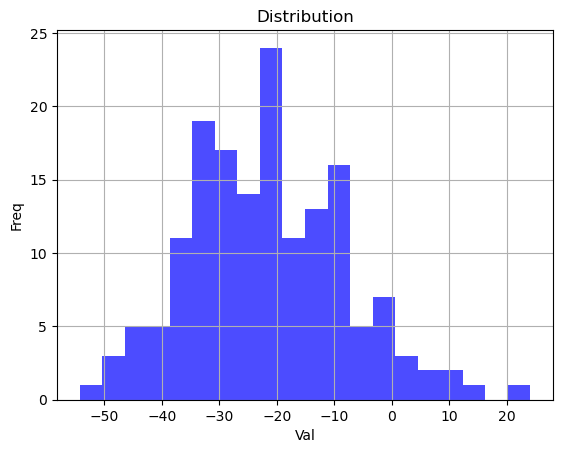

In [15]:
#Visualize the score distribution
plot_distribution(y_hat[0]) #The highest prob is significanlly higher than the others, 
#this is normal distributed, can use the mean + (2std as criteria to separate)

In [16]:
#Get the "probability" for each instance
import torch.nn as nn
softmax = nn.Softmax(dim=1) #Select the dimension that is going to be summed
prob = softmax(y_pred) 
best = torch.argmax(prob, dim=1)

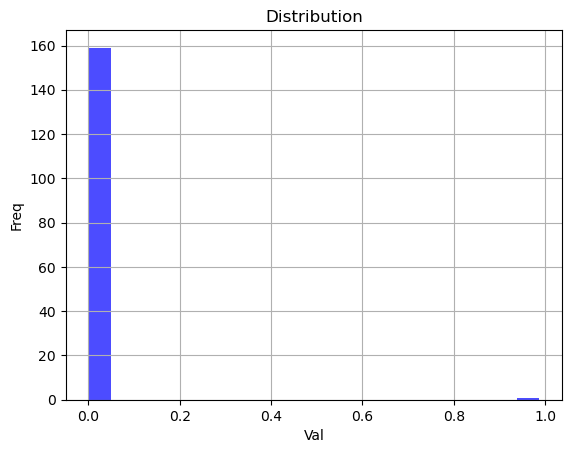

In [14]:
#Visualize the probability distribution
plot_distribution(prob[0]) #The highest prob is significanlly higher than the others, 
#but the prob "value" depends on the number of seq analized

### Probabilities distribution

In [26]:
prob_maxes = []
for i in range(len(best)):
    prob_max = torch.max(prob[i])
    prob_maxes.append(prob_max)
    prob_mean = torch.mean(prob[i])
    prob_std = torch.std(prob[i])
    print(f"for the set {i}: max: {prob_max} | mean: {prob_mean} | std: {prob_std}")
#Note: max probabilities are in general very low, but its because of the number of seq analyzed

for the set 0: max: 0.9876103401184082 | mean: 0.0062500000931322575 | std: 0.07807742804288864
for the set 1: max: 0.9999161958694458 | mean: 0.006250000558793545 | std: 0.07905027270317078
for the set 2: max: 0.9992204904556274 | mean: 0.0062500000931322575 | std: 0.07899495214223862
for the set 3: max: 0.9972654581069946 | mean: 0.0062500000931322575 | std: 0.0788395032286644
for the set 4: max: 0.9820683598518372 | mean: 0.0062500000931322575 | std: 0.07763463258743286
for the set 5: max: 0.96703040599823 | mean: 0.0062500000931322575 | std: 0.07647640258073807
for the set 6: max: 0.9998501539230347 | mean: 0.006249999161809683 | std: 0.07904502004384995
for the set 7: max: 0.9997848868370056 | mean: 0.0062500000931322575 | std: 0.07903982698917389
for the set 8: max: 0.9859445095062256 | mean: 0.0062499986961483955 | std: 0.07794081419706345
for the set 9: max: 0.9999005794525146 | mean: 0.0062500000931322575 | std: 0.07904903590679169
for the set 10: max: 0.9999537467956543 | mea

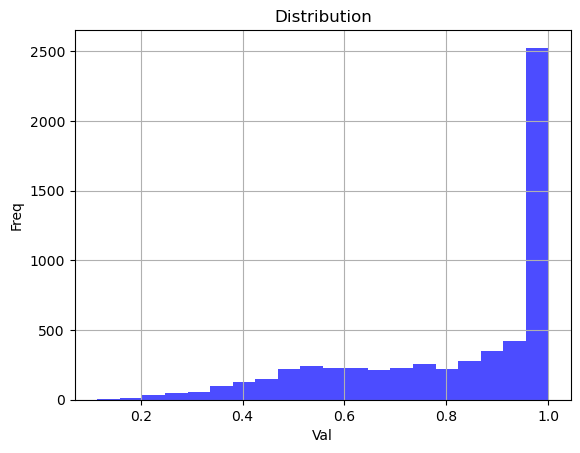

In [27]:
plot_distribution(prob_maxes) #Here you notice that some max values are very low, consider the threshold

### Scores distributions

In [20]:
#Analyze the scores instead of the "probabilities"
max_scores = []
for i in range(len(best)):
    score_max = torch.max(y_pred[i])
    score_mean = torch.mean(y_pred[i])
    score_std = torch.std(y_pred[i])
    print(f"for the set {i}: max: {score_max} | mean: {score_mean} | std: {score_std}")
    max_scores.append(score_max)

for the set 0: max: 87.48338317871094 | mean: 37.75089645385742 | std: 14.991427421569824
for the set 1: max: 61.911041259765625 | mean: 25.923465728759766 | std: 9.454065322875977
for the set 2: max: 45.11627960205078 | mean: 4.14265251159668 | std: 10.382085800170898
for the set 3: max: 37.23995590209961 | mean: 16.638795852661133 | std: 6.029942989349365
for the set 4: max: 50.621795654296875 | mean: 23.40158462524414 | std: 9.632781028747559
for the set 5: max: 35.9511833190918 | mean: 7.108074188232422 | std: 9.705230712890625
for the set 6: max: 42.4244499206543 | mean: 8.67658519744873 | std: 9.48035717010498
for the set 7: max: 54.69124221801758 | mean: 9.460376739501953 | std: 10.811454772949219
for the set 8: max: 21.929733276367188 | mean: 4.785959720611572 | std: 5.849554061889648
for the set 9: max: 60.49129867553711 | mean: 11.080002784729004 | std: 14.716959953308105
for the set 10: max: 68.0842514038086 | mean: 24.283288955688477 | std: 11.519083023071289
for the set 11

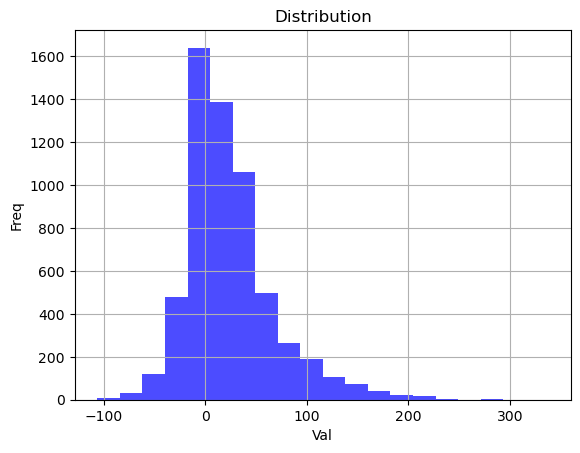

In [21]:
#Check if the max scores have similar magnitudes
plot_distribution(max_scores) #The max scores do differ and with a normal distribution, maybe because some max scores are actually not separated from the rest of the scores

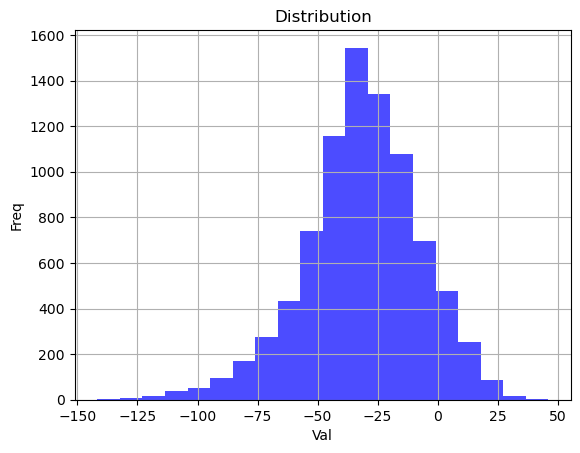

In [22]:
#Check if the scores have similar magnitudes (expecto to see a separation between max and mix but no)
plot_distribution(y_hat.reshape(1,-1)) #There you see some kind of normal distribution, 
#maybe is because the false positives dont allow to see a separation of the scores

In [ ]:
#Solution? Look on the true positive for the threshold of the probabily, and alternatibe is look for the scores 
# if there are one that is significantly different from other

# Threshold

In [49]:
true_prob = []
false_prob = []
true_score = []
false_score = []
for i in range(len(y_real)):
    if best[i] == y_real[i]: 
        true_prob.append(prob_maxes[i])
        true_score.append(max_scores[i])
    else: 
        false_prob.append(prob_maxes[i])
        false_score.append(max_scores[i])  

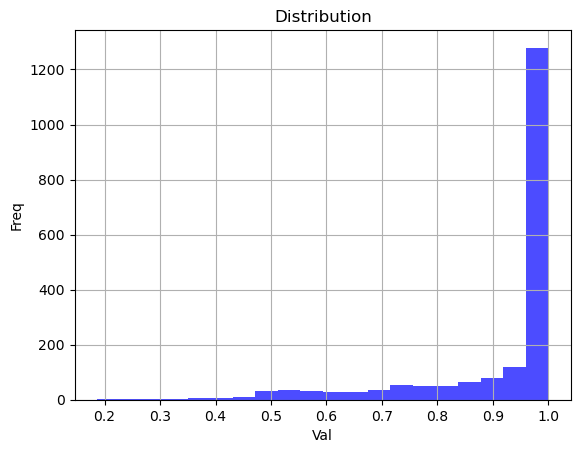

In [50]:
plot_distribution(true_prob)

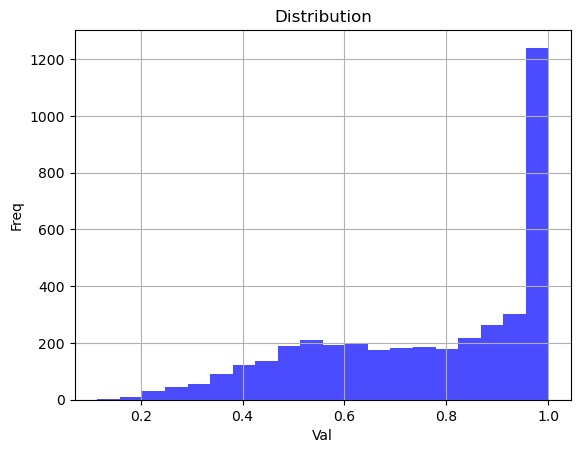

In [51]:
plot_distribution(false_prob)

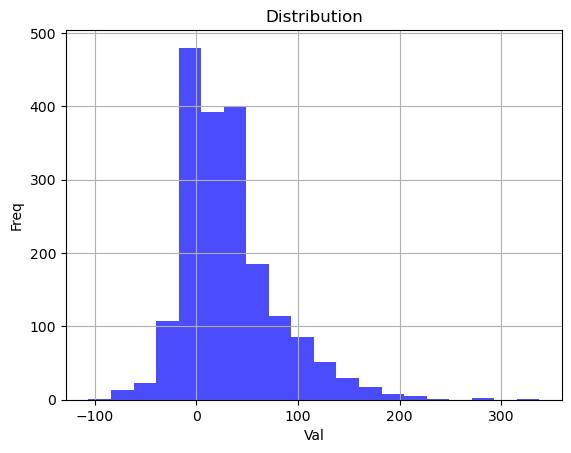

In [52]:
plot_distribution(true_score)

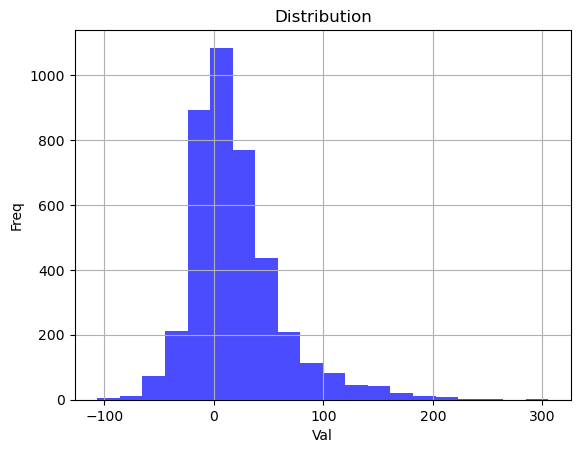

In [53]:
plot_distribution(false_score)

# Old

In [4]:
import h5py
import numpy as np
h5spectra = h5py.File("../Data/zsl_binned_new.h5t", "r")
#Get the labels of each set, to evaluate how the accuracy works there (omit)
ev_species = {}
#ev_species[b'train'] = []
ev_species[b'val_geni'] = [[],[],[]] #Strain, predict, real
ev_species[b'val_spec'] = [[],[],[]]
ev_species[b'val_strain'] = [[],[],[]]
study = [b'val_geni',b'val_spec',b'val_strain']
i = 0
for split in h5spectra["0"]["split_0"]:
    if split in study:
        vector = h5spectra["central"][i]
        label = np.where(vector == True)[0][0]
        #print(vector)
        #print(label)
        ev_species[split][0].append(h5spectra["1"]["strain_names"][label]) #is on bites transform to string
    i+=1

In [14]:
minibatch = next(iter(data_set))

In [15]:
for i in minibatch: print(i)

intensity
mz
group
strain
seq_names
seq_ohe


In [16]:
minibatch = next(iter(data_set))
minibatch #Use group, strain and seq_names

{'intensity': tensor([[1.1096e-04, 3.1383e-04, 2.5239e-04,  ..., 2.6381e-05, 2.9734e-05,
          2.9924e-05],
         [1.3825e-04, 2.3701e-04, 1.6831e-04,  ..., 8.5466e-06, 8.8299e-06,
          1.1711e-05],
         [1.9505e-04, 1.9167e-04, 5.6853e-05,  ..., 2.4509e-05, 1.9371e-05,
          1.4839e-05],
         ...,
         [3.1443e-06, 5.8273e-05, 9.7330e-05,  ..., 5.1822e-06, 0.0000e+00,
          5.9035e-07],
         [3.7632e-05, 2.1911e-05, 3.9686e-05,  ..., 3.7287e-06, 8.1477e-07,
          7.2644e-06],
         [1.4548e-05, 3.4723e-05, 6.1119e-06,  ..., 4.1520e-06, 6.1000e-06,
          9.9098e-06]]),
 'mz': tensor([[ 2001.5000,  2004.5000,  2007.5000,  ..., 19992.5000, 19995.5000,
          19998.5000],
         [ 2001.5000,  2004.5000,  2007.5000,  ..., 19992.5000, 19995.5000,
          19998.5000],
         [ 2001.5000,  2004.5000,  2007.5000,  ..., 19992.5000, 19995.5000,
          19998.5000],
         ...,
         [ 2001.5000,  2004.5000,  2007.5000,  ..., 19992.50

In [17]:
minibatch["group"][0]

'val_spec'

In [44]:
from maldi_zsl_edit.data import MALDITOFDataModule
data_path = "../Data/zsl_binned_new.h5t"
dm = MALDITOFDataModule( #Personalized lightning data modules
    data_path, #The old has problems on split
    zsl_mode = True, # False: multi-class CLF, True: ZSL
    split_index = 0, # independent train-val-test split numbered 0-9
    batch_size = 128, # important hyperparameter
    n_workers = 2, # you can leave this always if you are not CPU limited
    in_memory = True, # you can leave this always if memory is no problem
)
dm.setup(None)
data_set = dm.val_dataloader()
minibatch = next(iter(data_set))

In [36]:
#initilize dictionary:
ev_species = {}
splits = ['val_geni','val_spec','val_strain']
for split in splits:
    ev_species[split] = [set(),[],[]] #Strain, predict, real


In [40]:
import torch
#minibatch = next(iter(data_set))
#for split in ev_species:
#    ev_species[split][1] = torch.empty((0,len(ev_species[split][0])))
#Strain, predict, real
with torch.no_grad():
    for minibatch in iter(data_set): #On the split said if train, val, etc, 
        y_hat = torch.argmax(model(minibatch),axis=1)
        y_real = minibatch['strain']
        for i in range(len(y_real)): #128 is batch size
            split = minibatch["group"][i] 
            ev_species[split][0].add(minibatch['seq_names'][y_real[i]])
            ev_species[split][1].append(y_hat[i]) #= torch.cat((ev_species[split][1] ,y_hat),dim=0)
            ev_species[split][2].append(y_real[i])

#print(y_pred.shape) #(batch size, total possible species)
#y_pred

#Get the indexes and stavlis the resolution
#pred_ind = torch.argmax(y_pred, axis=1)
#real_ind = y_real

In [46]:
def accu_score(y_true, y_pred, level_lab):
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(level_lab)
    y_true_encoded = label_encoder.transform(y_true)
    y_pred_encoded = label_encoder.transform(y_pred)

    #Using sklearn
    #accu = accuracy_score(y_true_encoded, y_pred_encoded, normalize=True) #The normalize True = number of correct predictions, False = fraction of correct predictions
    
    #Using torch
    accu = Accuracy(task="multiclass", num_classes=len(set(level_lab))) 
    accu = accu(torch.tensor(y_pred_encoded), torch.tensor(y_true_encoded))
    
    return accu

#Create an F1 evaluator
def f1_macro_score(y_true, y_pred, level_lab): #micro average is basically accuracy
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(level_lab)
    y_true_encoded = label_encoder.transform(y_true)
    y_pred_encoded = label_encoder.transform(y_pred)

    #Using sklearn
    #f1_scores = f1_score(y_true_encoded, y_pred_encoded, average=None)
    #macro_f1 = sum(f1_scores) / len(f1_scores)

    #Using torch
    macro_f1 = F1Score(task="multiclass", num_classes=len(set(level_lab)), average='macro') 
    macro_f1 = macro_f1(torch.tensor(y_pred_encoded), torch.tensor(y_true_encoded))

    return macro_f1


In [47]:
from torchmetrics import F1Score
from sklearn.preprocessing import LabelEncoder
from torchmetrics import Accuracy

In [48]:
levels = ["Family", "Genus", "Species", "Strain"]
granularity_lvl = len(levels) 
for split in ev_species:
    #Get the indexes and stavlis the resolution
    pred_ind = ev_species[split][1]
    real_ind = ev_species[split][2]

    print(f"\n--- Multi level evaluation of {split} ---")
    #levels = ["Family", "Genus", "Species", "Strain"]
    
    filos = minibatch["seq_names"] 

    #Get the multilevel predictions, consider how the data is encoded (genus, species, strain)
    ml_real = []
    ml_pred = []
    for i in range(len(real_ind)):
        #for real:
        s_real = filos[real_ind[i]].split(";")
        ml_real.append(s_real)
        #for pred:
        s_pred = filos[pred_ind[i]].split(";")
        ml_pred.append(s_pred)

    #Get them on the right format
    ml_real = np.array(ml_real).T
    ml_pred = np.array(ml_pred).T
    #List for better iteratation
    ml_reals = ml_real.tolist()
    ml_preds = ml_pred.tolist()

    #Get all the possible multilevel labels (after this point consider the full filter)
    ml_level = []
    for i in range(len(filos)):
        s_level = filos[i].split(";")
        ml_level.append(s_level)
    ml_level = np.array(ml_level).T
    ml_levels = ml_level.tolist()

    #Total number of labels
    for i in range(granularity_lvl):
        n = len(list(set(ml_levels[i])))
        print(f"For {levels[i]} there are {n} different labels")

    print("\n--- Calculating Accuracy ---") # run accu for each level of complexity
    accu_levels = []
    for level in range(granularity_lvl ):
        accu_levels.append(accu_score(ml_reals[level], ml_preds[level], ml_levels[level]))

    # see the results
    for i in range(granularity_lvl ):
        print(f"For the level {levels[i]} the accu score is: {accu_levels[i]}") 

    print("\n--- Calculating F1 scores ---")# run f1_macro_score for each level of complexity
    F1_levels = []
    for level in range(granularity_lvl ):
        F1_levels.append(f1_macro_score(ml_reals[level], ml_preds[level], ml_levels[level]))

    # see the results
    for i in range(granularity_lvl ):
        print(f"For the level {levels[i]} the F1 score is: {F1_levels[i]}") #The predictions are no the same as the output, maybe F1 is not used there



--- Multi level evaluation of val_geni ---
For Family there are 33 different labels
For Genus there are 52 different labels
For Species there are 152 different labels
For Strain there are 160 different labels

--- Calculating Accuracy ---
For the level Family the accu score is: 0.5741882920265198
For the level Genus the accu score is: 0.5443181991577148
For the level Species the accu score is: 0.29107141494750977
For the level Strain the accu score is: 0.26428571343421936

--- Calculating F1 scores ---
For the level Family the F1 score is: 0.3146974742412567
For the level Genus the F1 score is: 0.28721338510513306
For the level Species the F1 score is: 0.13262474536895752
For the level Strain the F1 score is: 0.12146567553281784

--- Multi level evaluation of val_spec ---
For Family there are 33 different labels
For Genus there are 52 different labels
For Species there are 152 different labels
For Strain there are 160 different labels

--- Calculating Accuracy ---
For the level Family

In [11]:
#Info of the data set
import h5py
h5spectra = h5py.File("../Data/zsl_binned_new.h5t", "r") # The old version has problems on the split
#h5spectra.visititems(print) #See the data
#There are train: 463, val :160 and test: 165 
#torch.cuda.empty_cache() 

In [12]:
#Separate the predictions to look their individual accuracies
import numpy as np
ev_species = {}
ev_species[b'train'] = []
ev_species[b'val_geni'] = []
ev_species[b'val_spec'] = []
ev_species[b'val_strain'] = []
study = [b'train',b'val_geni',b'val_spec',b'val_strain']
i = 0
for label in h5spectra["0"]["split_0"]:
    if label in study:
        a = h5spectra["central"][i]
        b = np.where(a == True)[0][0]
        ev_species[label].append(b)
    i+=1

In [13]:
#Manual calculation of the predictions

import torch
y_pred = torch.empty((0,160)) #the second is the number of species #Change to 788 or 463 for val vs train
y_real= []
with torch.no_grad():
    for minibatch in iter(dm.val_dataloader()): #On the split said if train, val, etc, 
        y_hat = model(minibatch)
        y_pred = torch.cat((y_pred,y_hat),dim=0)
        y_real+= list(minibatch['strain'])
print(y_pred.shape) #(batch size, total possible species)
y_pred

torch.Size([5941, 160])


tensor([[-26.6596, -24.7468, -27.5153,  ..., -40.4013, -24.6716, -27.3861],
        [-44.8781, -36.4867, -35.9950,  ..., -56.0938, -38.7423, -45.9434],
        [-12.2353, -15.5614, -13.2962,  ..., -22.6843, -12.1105, -21.2666],
        ...,
        [-28.7306, -31.2096, -27.5706,  ..., -46.6892, -49.7223, -28.9330],
        [-52.5257, -53.3985, -47.9212,  ..., -75.5992, -76.6577, -52.0940],
        [-34.3973, -34.1811, -26.4999,  ..., -49.5889, -46.2922, -28.2480]])

## Labels for Multilevel evaluation

In [14]:
pred_ind = torch.argmax(y_pred, axis=1)
real_ind = y_real
levels = ["Family", "Genus", "Species", "Strain"]
granularity_lvl = len(levels) 

In [15]:
filos = minibatch["seq_names"]

In [16]:
#Get the multilevel predictions, consider how the data is encoded (genus, species, strain)
ml_real = []
ml_pred = []
for i in range(len(y_real)):
  #for real:
  s_real = filos[real_ind[i]].split(";")
  ml_real.append(s_real)
  #for pred:
  s_pred = filos[pred_ind[i]].split(";")
  ml_pred.append(s_pred)

In [17]:
#Get them on the right format
import numpy as np
ml_real = np.array(ml_real).T
ml_pred = np.array(ml_pred).T
#List for better iteratation
ml_reals = ml_real.tolist()
ml_preds = ml_pred.tolist()

In [18]:
#Get all the possible multilevel labels
ml_level = []
for i in range(len(filos)):
  s_level = filos[i].split(";")
  ml_level.append(s_level)
ml_level = np.array(ml_level).T
ml_levels = ml_level.tolist()

In [19]:
#Total number of labels
for i in range(granularity_lvl):
    n = len(list(set(ml_levels[i])))
    print(f"For {levels[i]} there are {n} different labels")

For Family there are 33 different labels
For Genus there are 52 different labels
For Species there are 152 different labels
For Strain there are 160 different labels


## Accuracy evaluation

In [20]:
#from sklearn.metrics import accuracy_score #There is also a torch version, consider it
from sklearn.preprocessing import LabelEncoder
from torchmetrics import Accuracy

#Create a accuracy evaluator
def accu_score(y_true, y_pred, level_lab):
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(level_lab)
    y_true_encoded = label_encoder.transform(y_true)
    y_pred_encoded = label_encoder.transform(y_pred)

    #Using sklearn
    #accu = accuracy_score(y_true_encoded, y_pred_encoded, normalize=True) #The normalize True = number of correct predictions, False = fraction of correct predictions
    
    #Using torch
    accu = Accuracy(task="multiclass", num_classes=len(set(level_lab))) 
    accu = accu(torch.tensor(y_pred_encoded), torch.tensor(y_true_encoded))
    
    return accu

In [21]:
# run accu for each level of complexity
accu_levels = []
for level in range(granularity_lvl ):
  accu_levels.append(accu_score(ml_reals[level], ml_preds[level], ml_levels[level]))

In [22]:
# see the results
for i in range(granularity_lvl ):
  print(f"For the level {levels[i]} the accu score is: {accu_levels[i]}") 

For the level Family the accu score is: 0.6105032563209534
For the level Genus the accu score is: 0.5556303858757019
For the level Species the accu score is: 0.2676317095756531
For the level Strain the accu score is: 0.2420467883348465


## F1 evaluation

In [23]:
#from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from torchmetrics import F1Score

#Create an F1 evaluator
def f1_macro_score(y_true, y_pred, level_lab): #micro average is basically accuracy
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(level_lab)
    y_true_encoded = label_encoder.transform(y_true)
    y_pred_encoded = label_encoder.transform(y_pred)

    #Using sklearn
    #f1_scores = f1_score(y_true_encoded, y_pred_encoded, average=None)
    #macro_f1 = sum(f1_scores) / len(f1_scores)

    #Using torch
    macro_f1 = F1Score(task="multiclass", num_classes=len(set(level_lab)), average='macro') 
    macro_f1 = macro_f1(torch.tensor(y_pred_encoded), torch.tensor(y_true_encoded))

    return macro_f1

In [24]:
# run f1_macro_score for each level of complexity
F1_levels = []
for level in range(granularity_lvl ):
  F1_levels.append(f1_macro_score(ml_reals[level], ml_preds[level], ml_levels[level]))

In [25]:
# see the results
for i in range(granularity_lvl ):
  print(f"For the level {levels[i]} the F1 score is: {F1_levels[i]}") #The predictions are no the same as the output, maybe F1 is not used there

For the level Family the F1 score is: 0.2802780866622925
For the level Genus the F1 score is: 0.2948206663131714
For the level Species the F1 score is: 0.19715124368667603
For the level Strain the F1 score is: 0.1872057020664215
